# Section 1 : Business Understanding
We will analyze Seattle AirBnB data using a basic Random Forest Regressor to try to answer 3 main questions: 
1. What is the main factors that drive the listing price ? 
2. Does the location of the property affect the price ? 
3. Does the time of the booking affect the price ? 

# Section 2 : Data Understanding


### Reading the data and importing package
We will use only 2 files in the dataset : listings.csv which contains the information about the property, and calendar.csv which is the transactional table that contains time and price of the booking. There is another file in the dataset (reviews.csv) but we will not use here since it require NLP techniques which are not covered in the scope of this project

In [1]:
#Imports

import os
os.getcwd()
os.chdir('G:\SeatleAirBnbData')

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [2]:
calendar_df = pd.read_csv('../SeatleAirBnbData/calendar.csv')
listing_df = pd.read_csv('../SeatleAirBnbData/listings.csv')

### Feature Engineering

### Listing table
First let's take a look at the categorical features

In [3]:
df2 = listing_df.describe(include = ['object']).transpose()
df2

,count,unique,top,freq
listing_url,3818,3818,https://www.airbnb.com/rooms/3732103,1
last_scraped,3818,1,2016-01-04,3818
name,3818,3792,Capitol Hill Apartment,3
summary,3641,3478,This is a modern fully-furnished studio apartm...,15
space,3249,3119,"*Note: This fall, there will be major renovati...",14
...,...,...,...,...
jurisdiction_names,3818,1,WASHINGTON,3818
instant_bookable,3818,2,f,3227
cancellation_policy,3818,3,strict,1417
require_guest_profile_picture,3818,2,f,3497


We can see that there are some categorical features which has only 1 unique value. We should drop these as they provide no information to our model. 

In [4]:
df3 = df2.loc[df2['unique'] == 1 ] # filtering categorical columns for those with only 1 unique values
only_one_unique= df3.index
listing_df_clean = listing_df.drop(only_one_unique, axis=1)

Also there are some "url" features, which are often unique urls for the listings. We can drop these as the information here is not really relevant

In [5]:
#dropping "url" columns
url_col = []
for col in listing_df.columns:
    if "url" in col: 
        url_col.append(col)
listing_df_clean = listing_df_clean.drop(url_col, axis=1)

Sanity check

In [6]:
listing_df_clean.describe(include = 'object')

,name,summary,space,description,neighborhood_overview,notes,transit,host_name,host_since,host_location,...,security_deposit,cleaning_fee,extra_people,calendar_updated,first_review,last_review,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,3818,3641,3249,3818,2786,2212,2884,3816,3816,3810,...,1866,2788,3818,3818,3191,3191,3818,3818,3818,3818
unique,3792,3478,3119,3742,2506,1999,2574,1466,1380,120,...,46,118,45,34,984,321,2,3,2,2
top,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,Wallingford is a mostly-residential neighborho...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,Andrew,2013-08-30,"Seattle, Washington, United States",...,$100.00,$50.00,$0.00,today,2015-09-21,2016-01-02,f,strict,f,f
freq,3,15,14,10,17,39,32,56,51,3259,...,348,310,2048,706,25,94,3227,1417,3497,3443


We will drop name, summary, space, description, neighborhood_overview, notes, transit, host_name first since the information here are generally not very useful (name and host_name could be anything and we will need NLP technique to utilize notes or description, which again will not be covered here )

In [7]:
listing_df_clean = listing_df_clean.drop (['name', 'summary', 'space', 'description', 
                        'neighborhood_overview', 'notes', 'transit', 'host_name','calendar_updated'], axis = 1)

State, city and smart_location ( which is nothing but a combination of state and city) should contain only “WA” and “Seattle”, which should be filtered out from the beginning. Let's see why

In [8]:
listing_df_clean['state'].value_counts()

WA    3817
wa       1
Name: state, dtype: int64

In [9]:
listing_df_clean['city'].value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
Ballard, Seattle            1
西雅图                         1
seattle                     1
Phinney Ridge Seattle       1
Name: city, dtype: int64

In [10]:
listing_df_clean['smart_location'].value_counts()

Seattle, WA                  3810
Seattle , WA                    2
West Seattle, WA                2
Ballard, Seattle, WA            1
Phinney Ridge Seattle, WA       1
西雅图, WA                         1
seattle, wa                     1
Name: smart_location, dtype: int64

It looks like some formatting errors and/or data entry error. We can safely remove these columns

In [11]:
listing_df_clean = listing_df_clean.drop (['city','state', 'smart_location'], axis = 1)

host_location & host_neighbourhood is the physical location of the owners of the property, which might not be important since we analyzing the property itself, not their owner. There might be cases where this could be useful (for example, if we have more information about the average income of where they live) but not here.

host_about is the host introduction of themselves. We will need NLP again.

host_verifications is the method the owners use to verify/confirm the booking. Pretty standard in today’s world (email, facebook, etc.). Email is the minimum standard and let’s be honest, who cares about the rest ?

Let’s drop all these.

In [12]:
listing_df_clean = listing_df_clean.drop (['host_location','host_about', 'host_verifications', 'host_neighbourhood'], axis = 1)

Let's take a look at the neighbourhood columns:


In [13]:
listing_df_clean['neighbourhood'].value_counts()

Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
Queen Anne            187
                     ... 
Pike Market             2
South Park              2
Fairmount Park          1
North College Park      1
Roxhill                 1
Name: neighbourhood, Length: 81, dtype: int64

In [14]:
listing_df_clean['neighbourhood_cleansed'].value_counts()

Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
South Beacon Hill      4
Pinehurst              4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64

In [15]:
listing_df_clean['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

‘neighbourhood’, ‘neighbourhood_cleansed’ and ‘neighbourhood_group_cleansed’ looks pretty similar to each other. We should only use one of these. Let’s use neighbourhood_group_cleansed since it contains less unique values, so we can avoid overfitting when we one hot encode this to fit our model later. Zipcode is also redundant here. Street is too detailed information and can lead to overfitting as well.

In [16]:
listing_df_clean = listing_df_clean.drop (['neighbourhood','neighbourhood_cleansed', 'zipcode','street'], axis = 1)

We will also drop the price columns since we know for a fact that the price set by the owner heavily influent the final listing price. We want to look at the rest of the features to find which one is more important

In [17]:
listing_df_clean = listing_df_clean.drop (['weekly_price','monthly_price','price'], axis = 1)

There are some categorical features which is really not categorical in nature. They are instead boolean. We will convert all of these boolean features into integer with 0 and 1, also we will impute all the missing value with 0 as well

In [18]:
boolean_df = ['host_is_superhost','host_has_profile_pic',
                               'host_identity_verified', 'is_location_exact',
                               'instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
listing_df_clean[boolean_df] = listing_df_clean[boolean_df].applymap(lambda x: 1 if x == "t" else 0)

There are some categorical features which is actually numerical. They are related to currency or percentage. For currency, we will remove the dollar sign and convert them to float. For percentage, we will remove the sign and divide by 100.

In [19]:
currency_col = ['security_deposit', 'cleaning_fee','extra_people']
for col in currency_col: 
    listing_df_clean[col] = listing_df_clean[col].str.replace("[$,]","").astype(float)

In [20]:
rate_col = ['host_response_rate', 'host_acceptance_rate']
for col in rate_col: 
    listing_df_clean[col] = listing_df_clean[col].str.replace("[%]","").astype(float).apply(lambda x: x/100).fillna(0)

There are some features related to date and time. First we will need to convert them to timestamp. Second, it doesn't make much sense to just use the timestamp since there is little useful information there. We will instead convert them to day difference between the datetime value and the date that the data was collected 

In [21]:
time_col = ['host_since','first_review','last_review']
basedate = pd.Timestamp('2016-01-04')
for col in time_col:
    listing_df_clean[col] = pd.to_datetime(listing_df_clean[col] , format = "%Y-%m-%d").apply(lambda x : (basedate-x).days).fillna(0)

The amenities feature contains a list of amennities available at the property. We should break these down into boolean features like is_wifi_available or is_parking_available and give them value 1 or 0. 

In [22]:
def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

values_dict = {}
for unique_value in listing_df_clean['amenities'].unique(): 
    for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
        if value in values_dict:
              values_dict[value] = values_dict[value] + 1
        else:
              values_dict[value] = 0
              
values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
    
    #split into columns
for value in values_sorted[: 10]:
      listing_df_clean['amenities' + '_' + value[0]] = listing_df_clean.apply(lambda row: get_val_from_list(row, 'amenities', value[0]),axis=1)
#drop original column
listing_df_clean = listing_df_clean.drop('amenities', axis = 1)

One hot encoding the rest of the categorical features

In [23]:
cat_df = listing_df_clean.select_dtypes(include = 'object')
cat_cols_lst = cat_df.columns
for col in cat_cols_lst:
    listing_df_clean = pd.concat([listing_df_clean.drop(col, axis = 1), pd.get_dummies(listing_df_clean[col]
                                                                                                , prefix = col, prefix_sep = "_", dummy_na = True)], axis = 1)

For numerical features, we will take a look at how much value is missing for each column. If the number of missing value is too high then we will drop those and then impute the rest with the median value. 


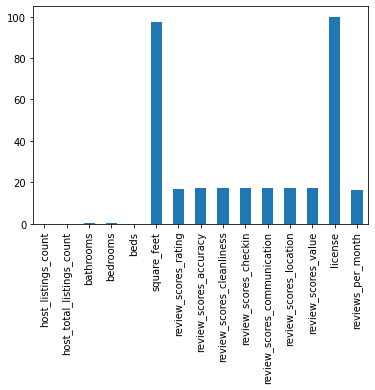

In [24]:
#extracting numerical feature
num_df = listing_df.select_dtypes(exclude = 'object')
# calculate percentage of missing value
listing_missing_num = num_df.isnull().mean()*100

#plot the results
nan_col = listing_missing_num[listing_missing_num>0]
nan_col.plot.bar()

Looks like we can drop square_feet and license since these are almost 100% empty. We can also drop longitude, latitude, scrape_id and host_id since it is irrelevant.

In [25]:
# dropping columns
listing_df_clean = listing_df_clean.drop(['square_feet', 'license','scrape_id', 'host_id','longitude','latitude'], axis = 1)

# fill the rest with median
listing_df_clean = listing_df_clean.fillna(listing_df_clean.median())

### Calendar table:
We will need to do some cleaning with the calendar table as well. 

Similar to what we did with the listing table, we will convert price from string to float value by removing the "$" and convert the datatype

Also the date grain is too small. We will convert them into month of year and then one hot encode them. We want to see which month is the most important in term of driving the price.

Finally we will remove all the rows which does not contain a listing price and also drop the available column since it will contain only 1 value after we remove the empty rows

In [26]:
#dropping available column
calendar_df_clean = calendar_df.drop('available', axis = 1)
#changing datatype of date column to datetime and convert to month
calendar_df_clean['date'] = pd.to_datetime(calendar_df_clean['date'] , format = "%Y-%m-%d").dt.month.astype(str)
#convert price to float values
calendar_df_clean['price'] = calendar_df_clean['price'].str.replace("[$,]","").astype(float)
#renaming columns
calendar_df_clean = calendar_df_clean.rename(columns = {'date': "month", 'price':'listing_price'})
#drop NaN and one hot encoding
calendar_df_clean = calendar_df_clean.dropna(axis=0)
calendar_df_clean= pd.concat([calendar_df_clean.drop('month', axis =1), pd.get_dummies(calendar_df_clean['month'], prefix ='month')], axis = 1)


In [27]:
calendar_df_clean

,listing_id,listing_price,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
1,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
9,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
10,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
14,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393207,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0
1393208,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0
1393211,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0
1393212,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0


For our final DataFrame, we need to join the calendar table with the listing table using "listing_id" and "id"

In [28]:
final_df = pd.merge (calendar_df_clean, listing_df_clean, how = 'left', left_on = 'listing_id', right_on = 'id' )

In [29]:
final_df

,listing_id,listing_price,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan
0,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934537,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
934538,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
934539,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
934540,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


### Data Modeling

Split into train and test dataset

In [30]:
test_size = 0.3
random_seed = 42

X = final_df.drop('listing_price', axis = 1)
y = final_df['listing_price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = random_seed)

Fit and train model

In [31]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=random_seed, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 186.466, test: 210.517
Random Forest R^2 train: 0.983, test: 0.981


### Evaluation 

### Question 1 : What is the most important factor for listing_price:

From the chart, we see that the two most important features are number of bedroom and number of bathroom. It fits with our common sense: bigger room is more expensive. It is the same with all hotels and motels in the world. 

Apart from that, the next couple of important features are : cleaning_fee, room_type and reviews per month. These also make sense




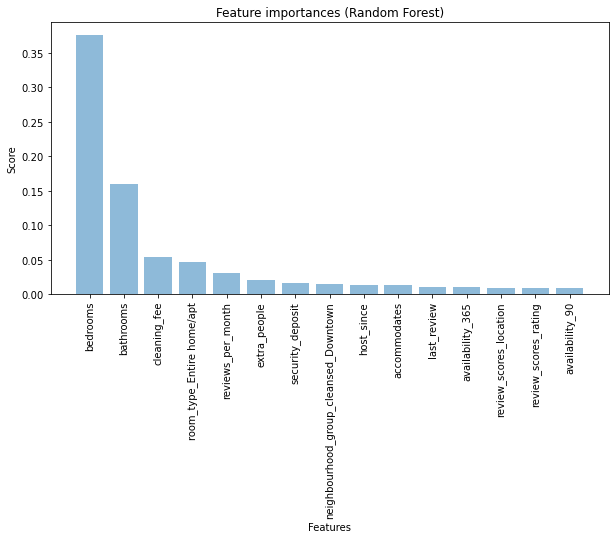

In [32]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

### Question 2 : Does the location of the property affect the price ?

Surprisingly, from the chart above, we see that location is not within the top features. Only Downtown make the list. It make senses since Downtown area is always more attractiveto tourist and business travellers and therefore more expensive . 

We can compare which neighborhood affect the price more 

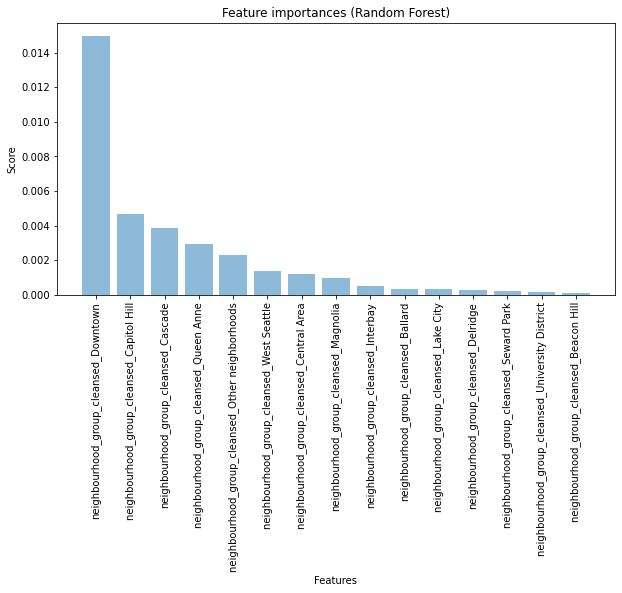

In [53]:
neighborhood = []
for col in forest_feature_importances['name']:
    if "neighbourhood_group_cleansed" in col: 
        neighborhood.append(col)
neighborhood_features_importance = forest_feature_importances[forest_feature_importances['name'].isin(neighborhood)]


features = neighborhood_features_importance['name'][:15]
y_pos = np.arange(len(features))
scores = neighborhood_features_importance['score'][:15]


#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

From this chart, we see that top 3 neighborhood are Downtown, Capital Hill and Cascade, which are also very close to Downtown Area. There is a clear difference among the neighborhoods. 

### Question 3: Does the time of the booking affect the price ?

From the chart, we see that June, July and August does indeed drive the price higher. This is coincide with the summer vacation. January and February is also high among the list. The difference between the rest is insignificant. 


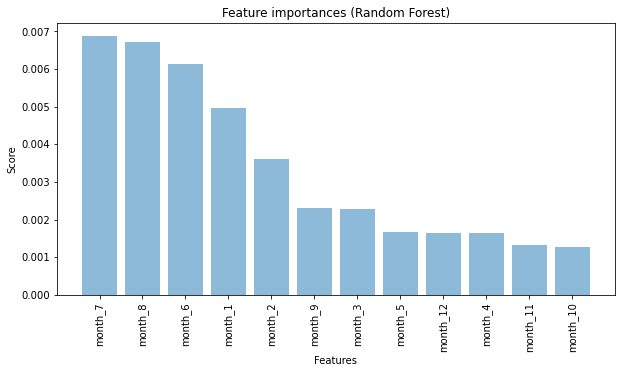

In [55]:
month = []
for col in forest_feature_importances['name']:
    if "month_" in col: 
        month.append(col)
month_features_importance = forest_feature_importances[forest_feature_importances['name'].isin(month)]


features = month_features_importance['name'][:15]
y_pos = np.arange(len(features))
scores = month_features_importance['score'][:15]


#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()